# Méthode de Monte Carlo

Tout d'abord, on illustre numériquement les deux résultats probabilistes sur lesquels reposent la méthode dite de Monte Carlo: 

- la loi forte de grands nombres,
- le théorème central limit (TCL).

On considère ensuite un premier exemple d'estimateur de Monte Carlo et l'importance de l'intervalle de confiance (IC) dans lequel se trouve la valeur recherchée avec probabilité grande (0.95). 

Enfin on applique la méthode de Monte Carlo à un exemple multidimensionnel où on illustre l'efficacité de 2 méthodes de réduction de variance: 

- variables antithétiques, 
- variable de contrôle. 

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng
rng = default_rng()

## Illustration de la loi des grands nombres

Soit $(X_n)_{n \ge 1}$ une suite de variables aléatoires _i.i.d._ de carré intégrable. On définit les suites $(m_n)_{n \ge 1}$ et $(\sigma_n^2)_{n \ge 2}$ (non définie pour $n = 1$) de la façon suivante

$$
  m_n = \frac{1}{n} \sum_{k=1}^n X_k \qquad \text{et} \qquad 
  \sigma_n^2 = \frac{1}{n-1} \sum_{k=1}^n (X_k - m_n)^2 \quad \text{pour} \; n \ge 2
$$
et on veut illustrer la Loi Forte des Grands Nombres et le Théorème Central Limite (étendu en utilisant le lemme de Slutsky pour remplacer $\sigma^2 = \mathrm{var}(X_1)$ par l'estimateur $\sigma_n^2$) c'est à dire les convergences

$$
  m_n \xrightarrow{p.s.} m \qquad \text{et} \qquad 
  \sqrt{n} \Bigl(\frac{m_n - m}{\sigma_n}\Bigr) \xrightarrow{\mathcal{L}} \mathcal{N}(0, 1).
$$

Plus précisément on construit l'intervalle de confiance (asymptotique) à 95% à partir du TCL c'est à dire

$$
  \text{pour $n$ grand} \quad \mathbf{P} \biggl( m \in 
  \biggl[
    m_n - \frac{1.96 \sigma_n}{\sqrt{n}}, 
    m_n + \frac{1.96 \sigma_n}{\sqrt{n}}
  \biggr] \biggr) \simeq 0.95
$$

### Question: LFGN loi uniforme

Reproduire le tracé suivant où les points (les croix 'x') sont les réalisations $X_n$ (en fonction de $n$) de loi uniforme sur $[-4,8]$. La ligne bleue (couleur 'C0', première couleur de la palette utilisée) correspond à la moyenne $m$, la courbe orangée (couleur 'C1') correspond à la suite $m_n$ et les lignes grises correspondent aux bornes de l'intervalle de confiance. La zone de confiance en jaune s'obtient par la méthode `fill_between` de `ax`.

![](img/tcl_unif.png)

[]

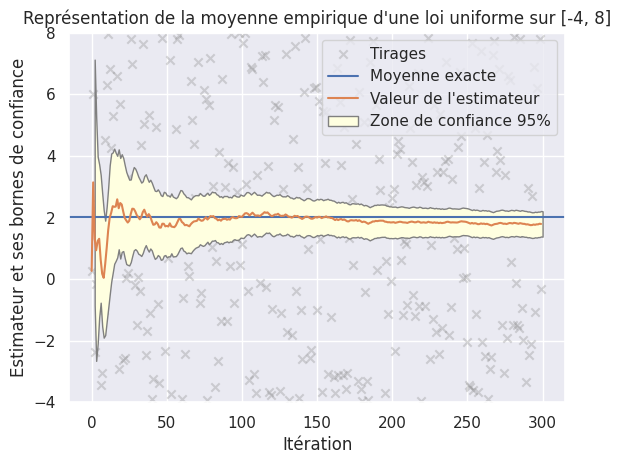

In [2]:
n = 300
low, high = -4, 8
n_list = np.arange(1,n+1)

support = np.arange(n)
sample = rng.uniform(low, high, n)

m = (low+high)/2
m_n = np.cumsum(sample)/n_list
var_n = (np.cumsum(sample**2)/n_list - m_n**2)[1:]       # var_n = moy(sample^2) - m_n^2

borne_inf = m_n[1:] - 1.96*np.sqrt(var_n/n_list[1:])
borne_sup = m_n[1:] + 1.96*np.sqrt(var_n/n_list[1:])


plt.scatter(support, sample, marker='x', color="grey", alpha=0.3, label="Tirages")
plt.axhline(m, color='C0', label="Moyenne exacte")
plt.plot(support, m_n, color='C1', label="Valeur de l'estimateur")
plt.fill_between(n_list[1:], borne_inf, borne_sup, edgecolor="grey", facecolor="lightyellow", label="Zone de confiance 95%")

plt.title(f'Représentation de la moyenne empirique d\'une loi uniforme sur [{low}, {high}]')
plt.xlabel("Itération")
plt.ylabel("Estimateur et ses bornes de confiance")
plt.ylim(low,high)
plt.legend()
plt.plot()


### Question: LFGN loi de Cauchy

Reprendre rapidement l'exemple précédent en remplaçant la loi uniforme par la loi de Cauchy. On obtient des réalisations de la loi de Cauchy en utilisant la méthode `standard_cauchy` de l'objet `rng`. Répliquer plusieurs fois le tracé (avec l'axe des ordonnées restreint à $[-10,10]$) pour différentes valeurs de $n=100\,000$. Qu'en pensez-vous? 

[]

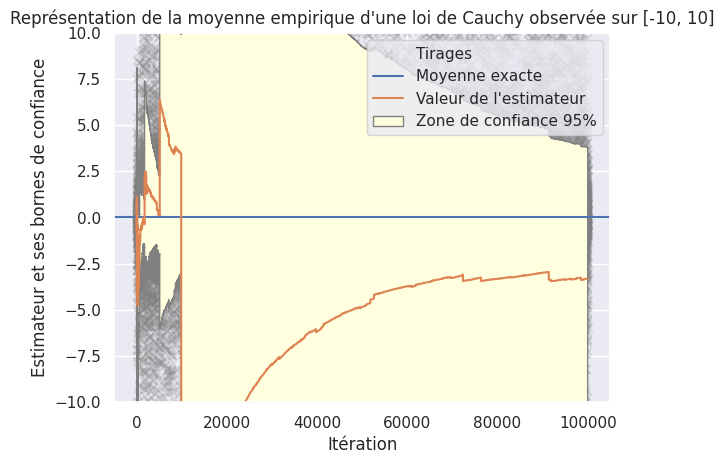

In [3]:
n = 100_000
low, high = -10, 10
n_list = np.arange(1,n+1)

support = np.arange(n)
sample = rng.standard_cauchy(n)

m = (low+high)/2
m_n = np.cumsum(sample)/n_list
var_n = (np.cumsum(sample**2)/n_list - m_n**2)[1:]       # var_n = moy(sample^2) - m_n^2

borne_inf = m_n[1:] - 1.96*np.sqrt(var_n/n_list[1:])
borne_sup = m_n[1:] + 1.96*np.sqrt(var_n/n_list[1:])

plt.scatter(support, sample, marker='x', color="grey", alpha=0.2, label="Tirages")
plt.axhline(m, color='C0', label="Moyenne exacte")
plt.plot(support, m_n, color='C1', label="Valeur de l'estimateur")
plt.fill_between(n_list[1:], borne_inf, borne_sup, edgecolor="grey", facecolor="lightyellow", label="Zone de confiance 95%")

plt.title(f'Représentation de la moyenne empirique d\'une loi de Cauchy observée sur [{low}, {high}]')
plt.xlabel("Itération")
plt.ylabel("Estimateur et ses bornes de confiance")
plt.ylim(low,high)
plt.legend()
plt.plot()

## Illustration du TCL 

On veut illustrer la répartition de l'erreur renormalisée $\displaystyle \varepsilon_n = \sqrt{n} \Bigl(\frac{m_n - m}{\sigma_n}\Bigr)$ pour différentes valeurs de $n$. Lorsque $n$ est grand cette erreur renormalisée est proche de la loi normale cenrée réduite, c'est ce qu'on veut vérifier numériquement. 
Pour illustrer cette répartition, il est nécessaire de répliquer un grand nombre de fois l'erreur c'est à dire de considérer un échantillon $(\varepsilon_n^{(j)})_{j=1,\dots,M}$ de taille $M$ et de constuire l'histogramme de cet échantillon.

**Attention:** en pratique il n'est pas nécessaire de répliquer $M$ fois l'estimateur $m_n$ pour approcher $m$. L'estimateur de la variance $v_n$ suffit pour donner la zone de confiance autour de $m_n$. C'est une information importante donnée par le TCL.

### Question: TCL loi uniforme 

Dans le cas de la loi uniforme sur $[-4, 8]$ vérifier la répartition de l'erreur renormalisée $\varepsilon_n$ pour $n = 10$ puis $n = 1\,000$ à partir d'un échantillon de taille $M = 100\,000$.

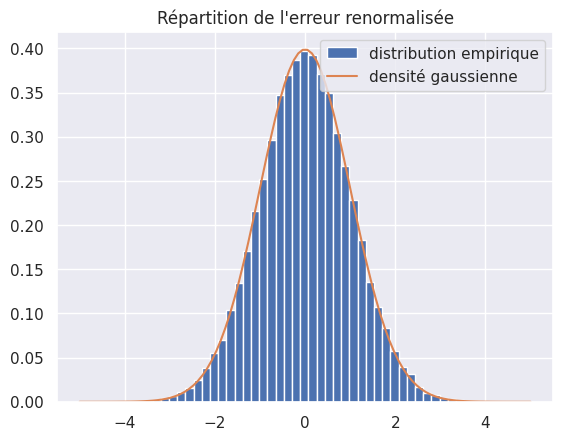

In [4]:
n = 100
M = 100_000
low, high = -4, 8

sample = rng.uniform(low, high, size=(n,M))

m = (low+high)/2
m_n = np.sum(sample, axis=0) / n
var_n = np.sum(sample**2, axis=0)/n - m_n**2      # var_n = moy(sample^2) - m_n^2
error_n = np.sqrt(n)*(m_n - m) / np.sqrt(var_n)


plt.hist(error_n, bins=50, density=True, label="distribution empirique", color='C0')
xx = np.linspace(-5, 5, 100)
plt.plot(xx, stats.norm.pdf(xx), label="densité gaussienne", color='C1')

plt.title("Répartition de l'erreur renormalisée")
plt.legend()
plt.show()

## Un premier exemple d'estimateur de Monte Carlo

On va mettre en oeuvre un estimateur de Monte Carlo pour calculer

$$
  I(\beta) = \mathbf{E}[\exp(\beta G)] \quad 
  \text{où $G \sim \mathcal{N}(0,1)$ et $\beta \in \mathbf{R}$}. 
$$

La valeur exacte $I(\beta) = \exp(\beta^2/2)$ est connue mais cet exemple permet d'illustrer l'importance des bornes de l'intervalle de confiance (et donc de l'estimation de la variance) dans une méthode de Monte Carlo. La seule valeur moyenne $I_n = \frac{1}{n} \sum_{k=1}^n X_k$ n'est pas suffisante pour déterminer $I$.

### Question: fonction `monte_carlo`

Ecrire une fonction `monte_carlo(sample, proba=0.95)` qui à partir d'un échantillon `sample` de réalisation indépendantes $(X_k)_{k=1,\dots,n}$ renvoie un tuple qui contient: 

- la moyenne de l'estimateur Monte Carlo de $I = \mathbf{E}[X]$,
- l'estimateur de la variance asymptotique apparaissant dans le TCL,
- les bornes inférieures et supérieures de l'intervale de confiance de niveau de probabilité `proba`.

In [16]:
def monte_carlo(sample, proba=0.95):
    moy = np.mean(sample)
    var = np.var(sample, ddof=1)
    n = len(sample)

    quantile = 1-stats.norm.ppf(1-(1-proba)/2)
    borne_inf = moy - quantile * np.sqrt(var/n)
    borne_sup = moy + quantile * np.sqrt(var/n)

    return moy, var, borne_inf, borne_sup

### Question: premier exemple

En utilisant la fonction `monte_carlo`, reproduire le tableau suivant où chaque ligne représente un résultat pour une valeur de $\beta \in \{0.2, 0.5, 1, 2, 3, 5\}$: 

- la première colonne est la valeur moyenne $I_n$,
- la deuxième colonne l'estimateur de la variance,
- les colonnes 3 et 4 sont les bornes inférieures et supérieurs de l'IC à 95%,
- la colonne 5 contient la valeur exacte $\mathbf{E}[\exp(\beta G)] = \exp(\beta^2/2)$.

Ce tableau est obtenu pour $n = 1\,000\,000$. Comment interpréter ce tableau? 

In [17]:
import pandas as pd
df = pd.read_pickle("data/first_df.pkl")
df

,mean,var,low,high,exact
0.2,1.020551,4.245536e-02,1.020147,1.020955,1.020201
0.5,1.134027,3.650418e-01,1.132843,1.135212,1.133148
1.0,1.651060,4.676691e+00,1.646821,1.655298,1.648721
2.0,7.402685,2.379946e+03,7.307068,7.498301,7.389056
3.0,87.915075,8.558333e+06,82.181273,93.648877,90.017131
5.0,121963.825619,6.439313e+14,72228.169429,171699.481809,268337.286521


In [19]:
n = 1_000_000
sample = rng.standard_normal(size=n)
betas = np.array([0.2, 0.5, 1, 2, 3, 5])

res = [monte_carlo(np.exp(beta*sample)) for beta in betas]

index_y = ["mean", "var", "low", "high"]
df = pd.DataFrame(res, index=betas, columns=index_y)
df["exact"] = np.exp(betas**2 /2)
df

,mean,var,low,high,exact
0.2,1.020310,4.252753e-02,1.020508,1.020112,1.020201
0.5,1.133544,3.658556e-01,1.134125,1.132963,1.133148
1.0,1.650777,4.733712e+00,1.652866,1.648689,1.648721
2.0,7.458773,3.659658e+03,7.516846,7.400700,7.389056
3.0,96.052891,4.357565e+07,102.389792,89.715991,90.017131
5.0,331163.330479,3.124370e+16,500845.474704,161481.186254,268337.286521


## Option panier: un exemple multidimensionnel

On considère $d \ge 2$ actifs financiers dont la loi à l'instant $T > 0$ est modélisée par une loi log-normale c'est à dire 
\begin{equation*}
    \forall i \in \{1,\dots,d\}, \quad
    S^i_T = S^i_0 \exp\Bigl( \bigl(r-\frac{\sigma_i^2}{2}\bigr) T + \sigma_i \sqrt{T} \tilde G_i \Bigr)
\end{equation*}
où le vecteur $(\tilde G_1,\dots, \tilde G_d)$ est gaussien centré de matrice de covariance $\Sigma$ et les constantes $r > 0$, $\sigma_i > 0$ sont fixées. Il s'agit d'actifs financiers $(S^i_t)_{t \in [0,T]}$, $1 \le i \le d$, modélisés par un processus de Black-Scholes multidimensionnel. On introduit la matrice $L$ triangulaire inférieure obtenue par la décomposition de Cholesky de la matrice $\Sigma = L L^\top$. 

A l'aide de cette matrice $L$, on définit la fonction $\Phi:\mathbf{R}^d \to \mathbf{R}^d$ telle que 
\begin{equation*}
    (S^1_T, \dots, S^d_T) = \Phi(G_1, \dots, G_d) \quad \text{ou encore} \quad S^i_T = \Phi_i(G_1, \dots, G_d)
\end{equation*}
où $(G_1, \dots, G_d) \sim \mathcal{N}(0, I_d)$ (l'égalité précédente est à considérer en loi).

On s'intéresse au prix d'une option européenne (aussi appelé produit dérivé européen) sur le panier de ces $d$ actifs financiers, c'est à dire qu'on veut calculer 
\begin{equation*}
    \mathbf{E} \bigl[ X \bigr] %\quad \text{avec} \quad g(x) = (x-K)_+ \quad \text{ou} \quad g(x) = (K-x)_+ 
    \quad \text{avec} \quad 
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_T  - K\biggr)_+.
\end{equation*}

### Question: initialisation 

Définir les paramètres globaux $d = 10$, $T = 1$, $r = 0.01$, $S^i_0 =100$ (pour tous les actifs), $\sigma_i = i / (2d)$ (on dit que certains actifs sont plus volatiles que d'autres) et la matrice de corrélation $\Sigma$ définie par $\Sigma_{i,i} = 1$ et $\Sigma_{i,j} = \rho \in [0,1]$ pour $i \neq j$, avec $\rho = 0.2$.

Initialiser la matrice $L$ en utilisant la fonction `np.linalg.cholesky`.

In [20]:
d = 10
T = 1
r = 0.01
rho = 0.2

S_0 = 100*np.ones(d)       # pour i de 1 à d
sigm = np.arange(1, d+1)/(2*d)
mat_corr = np.eye(d) + rho*(np.ones((d,d)) - np.eye(d))
L = np.linalg.cholesky(mat_corr)

### Question: simulation d'un échantillon d'actifs

Définir la fonction python `phi` qui transforme le vecteur $(G_1, \dots, G_d)$ en un vecteur $(S_T^1,\dots, S_T^d)$ (tous les paramètres sont des variables globales pour simplifier l'écriture du code). L'appel suivant doit fonctionner 
```
G = rng.standard_normal(size=d)
phi(G)
```
Si on veut implémenter un estimateur Monte Carlo il faut travailler avec des échantillons _i.i.d._ $(S^{(j)}_T)_{j=1,\dots,n}$ où $S^{(j)}_T = \big(S_T^{(j),1}, \dots, S_T^{(j),d}\big) \in \mathbf{R}^d$. Modifier votre fonction `phi` pour création un tel échantillon à partir de l'appel suivant: 
```
sample_G = rng.standard_normal(size=(d, n))
phi(sample_G)
```
(il faut utiliser la technique du broadcasting en `numpy`, c'est très important à connaitre en pratique).

In [21]:
def phi(G):
    G_tilde = L@G
    S_T = S_0[:, np.newaxis] * np.exp(T*(r - (sigm[:, np.newaxis]**2)/2) + sigm[:, np.newaxis]*np.sqrt(T)*G_tilde)
    return S_T

### Question: estimateur Monte Carlo 

Définir une fonction $\psi: \mathbf{R}^d \times \mathbf{R}_+ \to \mathbf{R}_+$ telle que
\begin{equation*}
  \psi(G_1, \dots, G_d, K) = 
  \biggl(\frac{1}{d} \sum_{i=1}^d \Phi_i(G_1, \dots, G_d) - K\biggr)_+
\end{equation*}
dans une fonction `python` appelée `psi`. Cette fonction doit fonctionner avec un échantillon $(G^{(j)}_1, \dots, G^{(j)}_d)_{j=1,\dots,n}$.  
Ecrire et programmer l'estimateur de Monte Carlo pour estimer la quantité $\mathbf{E}[X] = \mathbf{E}[\psi(G_1, \dots, G_d, K)]$ où $(G_1, \dots, G_d) \sim \mathcal{N}(0, I_d)$.  

Pour différentes valeur de $K \in \{80,90,100,110,120\}$ et $n = 100\,000$ vous devez obtenir le tableau suivant: 

In [22]:
df = pd.read_pickle("data/basket_mc.pkl")
df

,mean,var,lower,upper
80,21.394471,228.318772,21.300818,21.488123
90,12.860460,181.187947,12.777032,12.943889
100,6.655165,111.553749,6.589702,6.720627
110,2.998650,54.132985,2.953049,3.044252
120,1.204158,21.976278,1.175102,1.233213


In [23]:
def psi(G, K):
    d = G.shape[0]
    res = np.sum(phi(G), axis=0)/d - K
    return np.where(res>0, res, 0)

n = 100_000
Ks = np.array([80,90,100,110,120])
sample_G = rng.standard_normal(size=(d, n))

res_naif = [monte_carlo(psi(sample_G,K)) for K in Ks]

index_y = ["mean", "var", "lower", "upper"]
df = pd.DataFrame(res_naif, index=Ks, columns=index_y)
df

,mean,var,lower,upper
80,21.362589,228.363347,21.408464,21.316715
90,12.838796,180.927913,12.879629,12.797964
100,6.637374,111.417666,6.669417,6.605331
110,2.989087,54.111576,3.011417,2.966756
120,1.200031,22.068372,1.214292,1.185770


### Question: variables antithétiques 

Sur le même modèle que précédemment, implémenter la méthode de Monte Carlo avec réduction de variance par variables antithétiques c'est à dire basée sur la représentation: 
\begin{equation*}
    \mathbf{E}[X] = \mathbf{E} \Big[ \frac{1}{2} \bigl( \psi(G_1, \dots, G_d, K) + \psi(-G_1, \dots, -G_d, K) \bigr) \Big]
\end{equation*}
Calculer le ratio de variance (variance de la méthode naïve divisée par variance par variables antithétiques) pour les différentes valeurs de $K$.  
Que signifie ce ratio de variance?  


In [24]:
var_naif = np.array([monte_carlo(psi(sample_G,K))[1] for K in Ks])
var_antit = np.array([monte_carlo( (psi(sample_G,K)+psi(-sample_G,K)) /2 )[1] for K in Ks])

index_y = ["variance naif", "variance antithtique", "ratio"]
df = pd.DataFrame(np.transpose([var_naif, var_antit, var_naif/var_antit]), index=Ks, columns=index_y)
df

,variance naif,variance antithtique,ratio
80,228.363347,14.305123,15.963746
90,180.927913,26.107450,6.930126
100,111.417666,34.348356,3.243755
110,54.111576,22.897578,2.363201
120,22.068372,10.520385,2.097677


## Option panier: une variable de contrôle 

Dans le cas de la dimension 1 ($d=1$), le prix est donnée par une formule fermée, on appelle cette formule la formule de Black-Scholes. Pour une option Basket (en dimension $d \ge 2$) on approche le prix par Monte Carlo mais on peut utiliser des approximations pour construire un problème unidimensionnel proche du produit Basket. Ces approximations servent de variables de contrôles: **on ne rajoute pas une erreur, on retire de la variance**.

On rappelle que, en posant $\mu_i = r - \frac{1}{2}\sigma_i^2$,
\begin{equation*}
    X = \biggl(\frac{1}{d} \sum_{i=1}^d S^i_0 e^{\mu_i T + \sigma_i \sqrt{T}  G_i}  - K\biggr)_+
\end{equation*}
et en introduisant $a^i_0 = \frac{S^i_0}{\sum_{j=1}^d S^j_0}$ (t.q. $\sum a^i_0 = 1$) et $\bar S_0 = \frac{1}{d} \sum_{i=1}^d S^i_0$ on a 
\begin{equation*}
    X = \biggl(\bar S_0 \sum_{i=1}^d a^i_0 e^{\mu_i T + \sigma_i \sqrt{T}  G_i}  - K\biggr)_+.
\end{equation*}
La variable de contrôle proposée est obtenue en échangeant l'exponentielle et la moyenne pondérée par les poids $\big(a^i_0\big)_{i=1,\dots,d}$:
\begin{equation*}
    Y = \bigl(\bar S_0 e^Z  - K\bigr)_+
    \quad \text{avec} \quad 
    Z = \sum_{i=1}^d a^i_0 \big(\mu_i T + \sigma_i \sqrt{T}  G_i\big) 
\end{equation*}
La variable aléatoire $Z$ suit une loi gaussienne $Z \sim \mathcal{N}(m T, s^2 T)$ avec
\begin{equation*}
    m = \sum_{i=1}^d a^i_0 \mu_i
    \quad \text{et} \quad
    s^2 = \sum_{i=1}^d \Big( \sum_{j=1}^d a^i_0 \sigma_i L_{ij} \Big)^2. 
\end{equation*}
Ainsi l'espérance de la variable de contrôle $Y$ est connue par la formule de Black-Scholes, car elle correspond au prix d'un call de strike $K$ d'un actif Black-Scholes de dimension 1, de valeur initiale $\bar S_0$, de taux $\rho = m+\frac{1}{2} s^2$ et de volatilité $s$ (à un facteur d'actualisation près... attention à ça). On a donc 
\begin{equation*}
    e^{-\rho T} \mathbf{E} \big[ Y \big] = P_{\text{BS}}\big(\bar S_0, \rho, s, T, K\big),
\end{equation*}
où 
\begin{equation*}
    P_{\text{BS}}\big(x, r, \sigma, T, K\big) = x F_{\mathcal{N}(0,1)}(d_1) - K e^{-r T} F_{\mathcal{N}(0,1)}(d_2),
\end{equation*}
avec $F_{\mathcal{N}(0,1)}$ est la fonction de répartition de la loi normale centrée réduite et  la notation 
\begin{equation*}
    d_1 = \frac{1}{\sigma \sqrt{T}} \Big( \log\big( \frac{x}{K} \big) 
    + \big(r + \frac{\sigma^2}{2}\big) T \Big)
    \quad \text{et} \quad
    d_2 = d_1 - \sigma \sqrt{T}
\end{equation*}

### Question: préliminaires pour la variable de contrôle

- Définir la fonction `price_call_BS` qui code la fonction $P_{\text{BS}}\big(x, r, \sigma, T, K\big)$ définie ci-dessus.
- Initialiser les paramètres $\bar S_0$, $(a^i_0)_{i=1,\dots,d}$, $m$, $s^2$ et $\rho$.
- Calculer $\mathbf{E}[Y]$ par la formule fermée.
- Calculer $\mathbf{E}[Y]$ par un estimateur Monte Carlo à partir de réalisations de $( G_1^{(j)}, \dots,  G_d^{(j)})$, $j \in \{1, \dots, n\}$.
- Vérifier que tout est cohérent.

In [25]:
def price_call_BS(x, r, std, T, K):
    G_cr = stats.norm()

    d1 = (np.log(x/K) + T*(r+(std**2)/2)) / (std*np.sqrt(T))
    d2 = d1 - std*np.sqrt(T)

    res = x*G_cr.pdf(d1) - K*np.exp(-r*T)*G_cr.pdf(d2)
    return res

In [26]:
S0_barre = np.mean(S_0)
a_0 = S_0/np.sum(S_0)
m = a_0*(r-sigm**2 /2)
s_2 = np.sum( a_0*sigm * np.sum(L, axis=1))
print(s_2)

0.4756799111481067


### Question: MC avec variable de contrôle

Implémenter l'estimateur de Monte Carlo avec variable de contrôle pour le calcul de $\mathbf{E}[X]$ c'est à dire 
\begin{equation*}
    \mathbf{E}\big[ X \big] = \mathbf{E} \big[\psi(G_1,\dots,G_d,K) - (Y - \mathbf{E}[Y]) \big],
\end{equation*}
où $Y$ est la variable de contrôle introduite précédemment et $\mathbf{E}[Y]$ est calculée par la formule fermée.  
Comparer les ratios de variance pour les différentes valeurs de $K$.